# Predicting Movie Revenue

## Features  

**Variable to Predict:** Revenue


- Budget  
- Runtime  
- Genre  
- Release Date  
 - Season  
 - Holiday   
- Production Companies  
 - Number of companies involved  
 - Number of movies a company has made (previously)  
- Crew
 - Number of crewmembers  
- Cast
 - Gender Ratio for top 2/5/10/25
 - Number of previous movies top 10 cast have been in
- Collection
 - Is sequel (order)  


In [170]:
import numpy as np
import pandas as pd
import sqlite3
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, date
from scipy import stats

pd.set_option('display.float_format','{:,.2f}'.format)

In [171]:
db = sqlite3.connect(r'../../../Data Science Data/Unit 3/db.sqlite')

In [172]:
## SQL import statements to create dataframes

# Base dataframe to join other onto
base_df = pd.read_sql("""SELECT movie_id, budget, release_date, revenue, runtime, imdb_budget, imdb_revenue, title, collection 
                         FROM movies 
                         WHERE (budget > 0 OR imdb_budget > 0) AND (revenue > 0 OR imdb_revenue > 0)
                      """, db, index_col='movie_id', parse_dates=['release_date'])
base_df.index = base_df.index.map(int)

# Pull in genre table to create dummy variables
genre_df = pd.read_sql("""SELECT * FROM genres""", db)

# Create series for number of production companies associated with each movie_id
number_of_prod_companies = pd.read_sql("""SELECT movie_id, COUNT(company_name) AS prod_company_count
                                          FROM production_companies
                                          GROUP BY movie_id
                                          """, db, index_col='movie_id')
number_of_prod_companies.index = number_of_prod_companies.index.map(int)

production_companies = pd.read_sql("""
    SELECT *
    FROM production_companies
    """, db)
production_companies['movie_id'] = production_companies['movie_id'].map(int)

# Create series for number of crew members associated with each movie_id
number_of_crewmembers = pd.read_sql("""SELECT movie_id, COUNT(crew_member_id) AS crewmember_count
                                       FROM crew
                                       GROUP BY movie_id
                                       """, db, index_col='movie_id')
number_of_crewmembers.index = number_of_crewmembers.index.map(int)

# Dataframe for cast data to create gender ratio, and number of previous movies for cast
cast_data = pd.read_sql("""SELECT cc.movie_id, cc.cast_member_id, cc.cast_order, c.gender, m.release_date
                           FROM cast_credit cc
                           JOIN cast c ON cc.cast_member_id = c.cast_member_id
                           JOIN movies m ON cc.movie_id = m.movie_id
                                  """, db)
cast_data.index = cast_data.index.map(int)

In [173]:
# Create feature to note if the movie is a sequel
base_df.sort_values(['collection', 'release_date'], inplace=True)
base_df['order_in_collection'] = 1

current = None
counter = 1

for index, row in base_df.iterrows():
    if row['collection'] is None:
        break
    if current != row['collection']:
        counter = 1
    base_df.set_value(index,'order_in_collection', counter)
    current = row['collection']
    counter += 1

In [174]:
# Create feature for season
seasons = {
    1:'winter',
    2:'winter',
    3:'spring',
    4:'spring',
    5:'spring',
    6:'summer',
    7:'summer',
    8:'summer',
    9:'fall',
    10:'fall',
    11:'fall',
    12:'winter'
}

def season_for_date(date):
    if pd.notnull(date):
        return seasons[date.month]
    else:
        return None

movie_season = base_df['release_date'].apply(season_for_date)
movie_season.rename('season', inplace=True);

In [175]:
# Create feature for holiday
us_holidays = holidays.UnitedStates()

def check_holiday(date):
    if pd.notnull(date):
        return any((date + timedelta(days=i)) in us_holidays for i in range(-4,5))
    else:
        return None
    
movie_is_holiday = base_df['release_date'].apply(check_holiday)
movie_is_holiday.rename('is_holiday', inplace=True);

In [176]:
# Create feature for production company experience
production_companies_joined = production_companies.merge(base_df, left_on='movie_id', right_index=True, how='left')

production_companies_joined.sort_values(['company_name', 'release_date'], inplace=True)
production_companies_joined['movies_produced'] = 0

current = None
counter = 0

for index, row in production_companies_joined.iterrows():
    if current != row['company_name']:
        counter = 0
    production_companies_joined.set_value(index,'movies_produced', counter)
    current = row['company_name']
    counter += 1
    
production_company_experience = production_companies_joined.groupby(by='movie_id').sum()['movies_produced']

In [177]:
# Create feature for cast experience
cast_data.sort_values(['cast_member_id', 'release_date'], inplace=True)
cast_data['movie_experience'] = 0

current = None
counter = 0

for index, row in cast_data.iterrows():
    if current != row['cast_member_id']:
        counter = 0
    cast_data.set_value(index,'movie_experience', counter)
    current = row['cast_member_id']
    counter += 1
    
cast_experience = cast_data[cast_data['cast_order'] <= 10].groupby('movie_id').sum()['movie_experience']

In [178]:
# Create dummy variables for genre
pivot_genre = genre_df.pivot_table(index='movie_id',columns='genre_name', values='genre_name',aggfunc=len, fill_value=0)
pivot_genre.index = pivot_genre.index.map(int)
pivot_genre = pivot_genre.apply(pd.to_numeric)

In [179]:
# Create column for gender ratio
gender_data = cast_data[cast_data['gender'] != 0]
gender_data = gender_data[gender_data['cast_order'] <= 5]
gender_data['gender'] = gender_data['gender'] - 1
gender_data = gender_data.groupby(by='movie_id').mean()['gender']
gender_data.index = gender_data.index.map(int)

In [180]:
# Join 'em up
df = base_df.join(pivot_genre, how='inner')
df = df.join(number_of_prod_companies, how='inner')
df = df.join(number_of_crewmembers, how='inner')
df = df.join(gender_data, how='inner')
df = df.join(cast_experience, how='inner')
df = df.join(production_company_experience, how='inner')
df = df.join(movie_is_holiday, how='inner')
df = df.join(movie_season, how='inner')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6195 entries, 117263 to 394117
Data columns (total 36 columns):
budget                 6195 non-null int64
release_date           6195 non-null datetime64[ns]
revenue                6195 non-null int64
runtime                6188 non-null float64
imdb_budget            1938 non-null object
imdb_revenue           2007 non-null object
title                  6195 non-null object
collection             1254 non-null object
order_in_collection    6195 non-null int64
Action                 6195 non-null int64
Adventure              6195 non-null int64
Animation              6195 non-null int64
Comedy                 6195 non-null int64
Crime                  6195 non-null int64
Documentary            6195 non-null int64
Drama                  6195 non-null int64
Family                 6195 non-null int64
Fantasy                6195 non-null int64
Foreign                6195 non-null int64
History                6195 non-null int64
Horror     

In [181]:
df['complete_budget'] = df['budget'].replace(0,np.nan).fillna(df['imdb_budget'])
df['complete_revenue'] = df['revenue'].replace(0,np.nan).fillna(df['imdb_revenue'])

df['complete_budget'] = pd.to_numeric(df['complete_budget'],errors='coerce',downcast='integer')
df['complete_revenue'] = pd.to_numeric(df['complete_revenue'],errors='coerce',downcast='integer')

df['runtime'] = pd.to_numeric(df['runtime'],downcast='integer')
df['gender'] = pd.to_numeric(df['gender'],downcast='integer')

In [182]:
df['is_sequel'] = df['order_in_collection'] > 1
df['profit'] = df['complete_revenue'] - df['complete_budget']
df['ROI'] = df['profit'] / df['complete_budget']
df['gross_margin'] = df['complete_revenue'] / df['complete_budget']

In [183]:
cols_to_drop = ['budget','revenue','imdb_budget','imdb_revenue','collection','order_in_collection']
df.drop(cols_to_drop,axis=1,inplace=True)
df.dropna(inplace=True)
df.drop(df[df['release_date'].dt.year < 1965].index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5334 entries, 117263 to 394117
Data columns (total 36 columns):
release_date          5334 non-null datetime64[ns]
runtime               5334 non-null float64
title                 5334 non-null object
Action                5334 non-null int64
Adventure             5334 non-null int64
Animation             5334 non-null int64
Comedy                5334 non-null int64
Crime                 5334 non-null int64
Documentary           5334 non-null int64
Drama                 5334 non-null int64
Family                5334 non-null int64
Fantasy               5334 non-null int64
Foreign               5334 non-null int64
History               5334 non-null int64
Horror                5334 non-null int64
Music                 5334 non-null int64
Mystery               5334 non-null int64
Romance               5334 non-null int64
Science Fiction       5334 non-null int64
TV Movie              5334 non-null int64
Thriller              5334 non-nul

In [184]:
# Top 10 box office grossing movies
df.sort_values('complete_revenue',ascending=False,inplace=True)
df.head(n=10)

,release_date,runtime,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,movie_experience,movies_produced,is_holiday,season,complete_budget,complete_revenue,is_sequel,profit,ROI,gross_margin
movie_id,,,,,,,,,,,,,,,,,,,,,
1362,1977-11-27,77.00,The Hobbit,0,1,1,0,0,0,0,...,73,13,True,fall,"3,000,000.00","5,000,000,000.00",False,"4,997,000,000.00","1,665.67","1,666.67"
19995,2009-12-10,162.00,Avatar,1,1,0,0,0,0,0,...,145,604,False,winter,"237,000,000.00","2,787,965,087.00",False,"2,550,965,087.00",10.76,11.76
140607,2015-12-15,136.00,Star Wars: The Force Awakens,1,1,0,0,0,0,0,...,219,40,False,winter,"245,000,000.00","2,068,223,624.00",True,"1,823,223,624.00",7.44,8.44
597,1997-11-18,194.00,Titanic,0,0,0,0,0,0,1,...,154,1108,False,fall,"200,000,000.00","1,845,034,188.00",False,"1,645,034,188.00",8.23,9.23
24428,2012-04-25,143.00,The Avengers,1,1,0,0,0,0,0,...,327,811,False,spring,"220,000,000.00","1,519,557,910.00",False,"1,299,557,910.00",5.91,6.91
135397,2015-06-09,124.00,Jurassic World,1,1,0,0,0,0,0,...,204,205,False,summer,"150,000,000.00","1,513,528,810.00",True,"1,363,528,810.00",9.09,10.09
168259,2015-04-01,137.00,Furious 7,1,0,0,0,0,0,0,...,258,757,False,spring,"190,000,000.00","1,506,249,360.00",True,"1,316,249,360.00",6.93,7.93
99861,2015-04-22,141.00,Avengers: Age of Ultron,1,1,0,0,0,0,0,...,362,43,False,spring,"280,000,000.00","1,405,403,694.00",True,"1,125,403,694.00",4.02,5.02
12445,2011-07-07,130.00,Harry Potter and the Deathly Hallows: Part 2,0,1,0,0,0,0,0,...,296,896,True,summer,"125,000,000.00","1,342,000,000.00",True,"1,217,000,000.00",9.74,10.74


In [185]:
# The Hobbit animated movie?? Really? Let's remove... 
df.drop(df[df['title'] == 'The Hobbit'].index, inplace=True)

In [186]:
# Look at the lowest quantile to check for outliers
df[df['complete_revenue'] < df['complete_revenue'].quantile(q=.0075)]

# Notes
# Trojan War: Only released in one theater in the US over one weekend. Not a good representation of what we are trying to predict
# Sunrise: Foreign movie released in theaters in the US 2 years after originally released in France
# Skin Trade: Terrible movie that starred Dolph Lungren. With the exception of Rocky, his movies have been terrible. Something to model in the future?
# Next Time I'll Aim for the Heart: French movie. Grossed 4mil Euros, but did very little in the USA. 

,release_date,runtime,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,movie_experience,movies_produced,is_holiday,season,complete_budget,complete_revenue,is_sequel,profit,ROI,gross_margin
movie_id,,,,,,,,,,,,,,,,,,,,,
327833,2014-11-07,96.00,Skin Trade,1,0,0,0,0,0,1,...,266,2,True,fall,"9,000,000.00","1,242.00",False,"-8,998,758.00",-1.00,0.00
328930,2014-10-03,85.00,Sunrise,0,0,0,0,0,0,1,...,21,15,False,fall,"700,000.00","1,000.00",False,"-699,000.00",-1.00,0.00
298459,2014-11-12,111.00,Next Time I'll Aim for the Heart,0,0,0,0,1,0,1,...,80,52,True,fall,"5,100,000.00",714.00,False,"-5,099,286.00",-1.00,0.00
77633,2001-12-21,100.00,Big Shot's Funeral,0,0,0,1,0,0,0,...,182,346,True,winter,"3,300,000.00",646.00,False,"-3,299,354.00",-1.00,0.00
92493,2011-09-10,105.00,Edwin Boyd: Citizen Gangster,0,0,0,0,1,0,1,...,176,10,False,fall,"5,000,000.00",625.00,False,"-4,999,375.00",-1.00,0.00
14330,1997-09-26,85.00,Trojan War,0,0,0,1,0,0,0,...,19,696,False,fall,"15,000,000.00",217.00,False,"-14,999,783.00",-1.00,0.00
57186,2010-10-06,97.00,Skinning,1,0,0,0,1,0,1,...,80,2,False,fall,"500,000.00",198.00,False,"-499,802.00",-1.00,0.00
22717,2009-09-18,129.00,Wanted,1,0,0,1,1,0,0,...,305,4,False,fall,75.00,134.00,False,59.00,0.79,1.79
212769,2013-08-07,110.00,Make Your Move,0,0,0,0,0,0,0,...,29,37,False,summer,15.00,122.00,False,107.00,7.13,8.13


In [187]:
# Remove movies with a budget less than 100,000
df.drop(df[df['complete_budget'] < 100000].index,inplace=True)

upper_quantile_rev = df['complete_revenue'].quantile(q=.9)
bottom_quantile_rev = df['complete_revenue'].quantile(q=.1)
df.drop(df[df['complete_revenue'] < bottom_quantile_rev].index,inplace=True)
df.drop(df[df['complete_revenue'] > upper_quantile_rev].index,inplace=True)

df.describe()

,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,prod_company_count,crewmember_count,gender,movie_experience,movies_produced,complete_budget,complete_revenue,profit,ROI,gross_margin
count,"4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00",...,"4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00"
mean,110.23,0.26,0.16,0.04,0.38,0.17,0.00,0.49,0.09,0.09,...,2.93,24.68,0.68,119.54,239.34,"24,578,545.01","44,663,673.34","20,085,128.33",2.83,3.83
std,23.25,0.44,0.36,0.19,0.49,0.38,0.07,0.50,0.28,0.28,...,2.18,27.40,0.23,108.81,284.73,"25,258,574.26","50,203,064.34","42,478,970.04",15.89,15.89
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,1.00,0.00,0.00,0.00,"100,000.00","480,314.00","-165,710,090.00",-0.99,0.01
25%,96.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,9.00,0.50,55.00,20.00,"6,706,750.00","7,994,779.25","-4,526,847.00",-0.32,0.68
50%,106.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.00,15.00,0.67,97.00,92.00,"16,500,000.00","23,801,214.00","6,166,873.50",0.60,1.60
75%,120.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,4.00,29.00,0.83,151.00,426.00,"35,000,000.00","64,156,870.25","34,619,500.25",2.33,3.33
max,422.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,26.00,338.00,1.00,"1,295.00","1,791.00","255,000,000.00","213,954,274.00","207,954,274.00",652.85,653.85


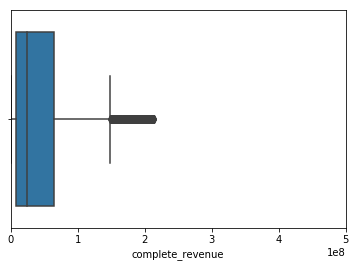

In [188]:
sns.boxplot(x=df['complete_revenue'])
plt.xlim(0,500000000)
plt.show()

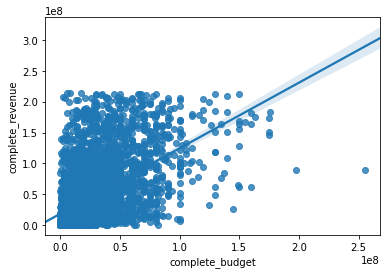

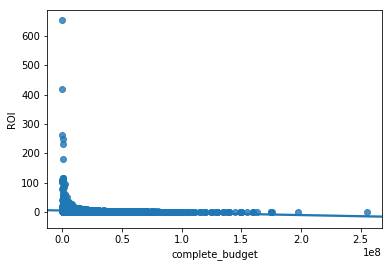

In [189]:
sns.regplot(y=df['complete_revenue'],x=df['complete_budget'])
plt.show() 

sns.regplot(y=df['ROI'],x=df['complete_budget'])
plt.show()

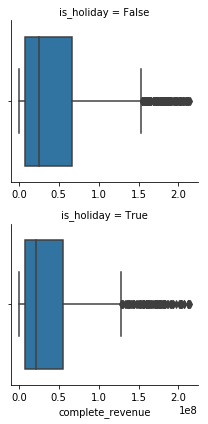

KruskalResult(statistic=3.9260132567033201, pvalue=0.047544530878936411)

In [190]:
g = sns.FacetGrid(df[['is_holiday','complete_revenue','complete_budget']],row='is_holiday')
g.map(sns.boxplot, 'complete_revenue')
plt.show()

stats.kruskal(df[df['is_holiday'] == True]['complete_revenue'], df[df['is_holiday'] == False]['complete_revenue'])

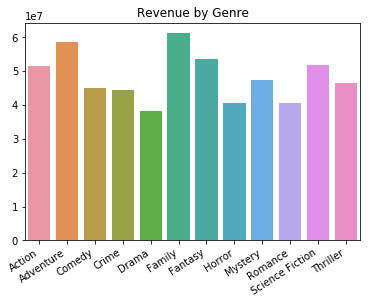

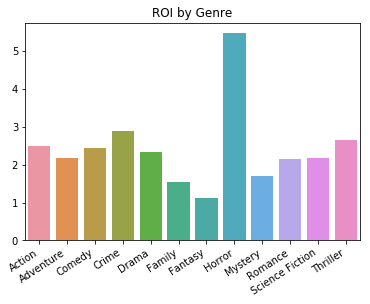

In [191]:
genres = list(genre_df.groupby('genre_name').count().index)

genre_count = {}

for genre in genres:
    genre_count[genre] = df[df[genre] == 1]['complete_revenue'].count()

genre_list = [key for key,values in genre_count.items() if values > 200]

genre_mean = {}
genre_ROI = {}

for genre in genre_list:
    genre_mean[genre] = df[df[genre] == 1]['complete_revenue'].mean()
    genre_ROI[genre] = df[df[genre] == 1]['ROI'].mean()
    
sns.barplot(x=list(genre_mean.keys()),y=[value for value in genre_mean.values()])
plt.title('Revenue by Genre')
plt.xticks(rotation=33, horizontalalignment='right')
plt.show()

sns.barplot(x=list(genre_mean.keys()),y=[value for value in genre_ROI.values()])
plt.title('ROI by Genre')
plt.xticks(rotation=33, horizontalalignment='right')
plt.show()

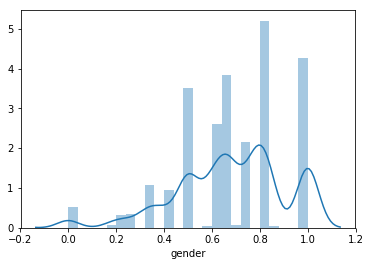

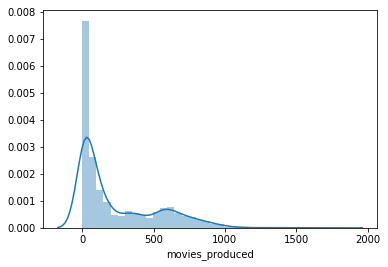

In [192]:
sns.distplot(df['gender'])
plt.show()

sns.distplot(df['movies_produced'])
plt.show()

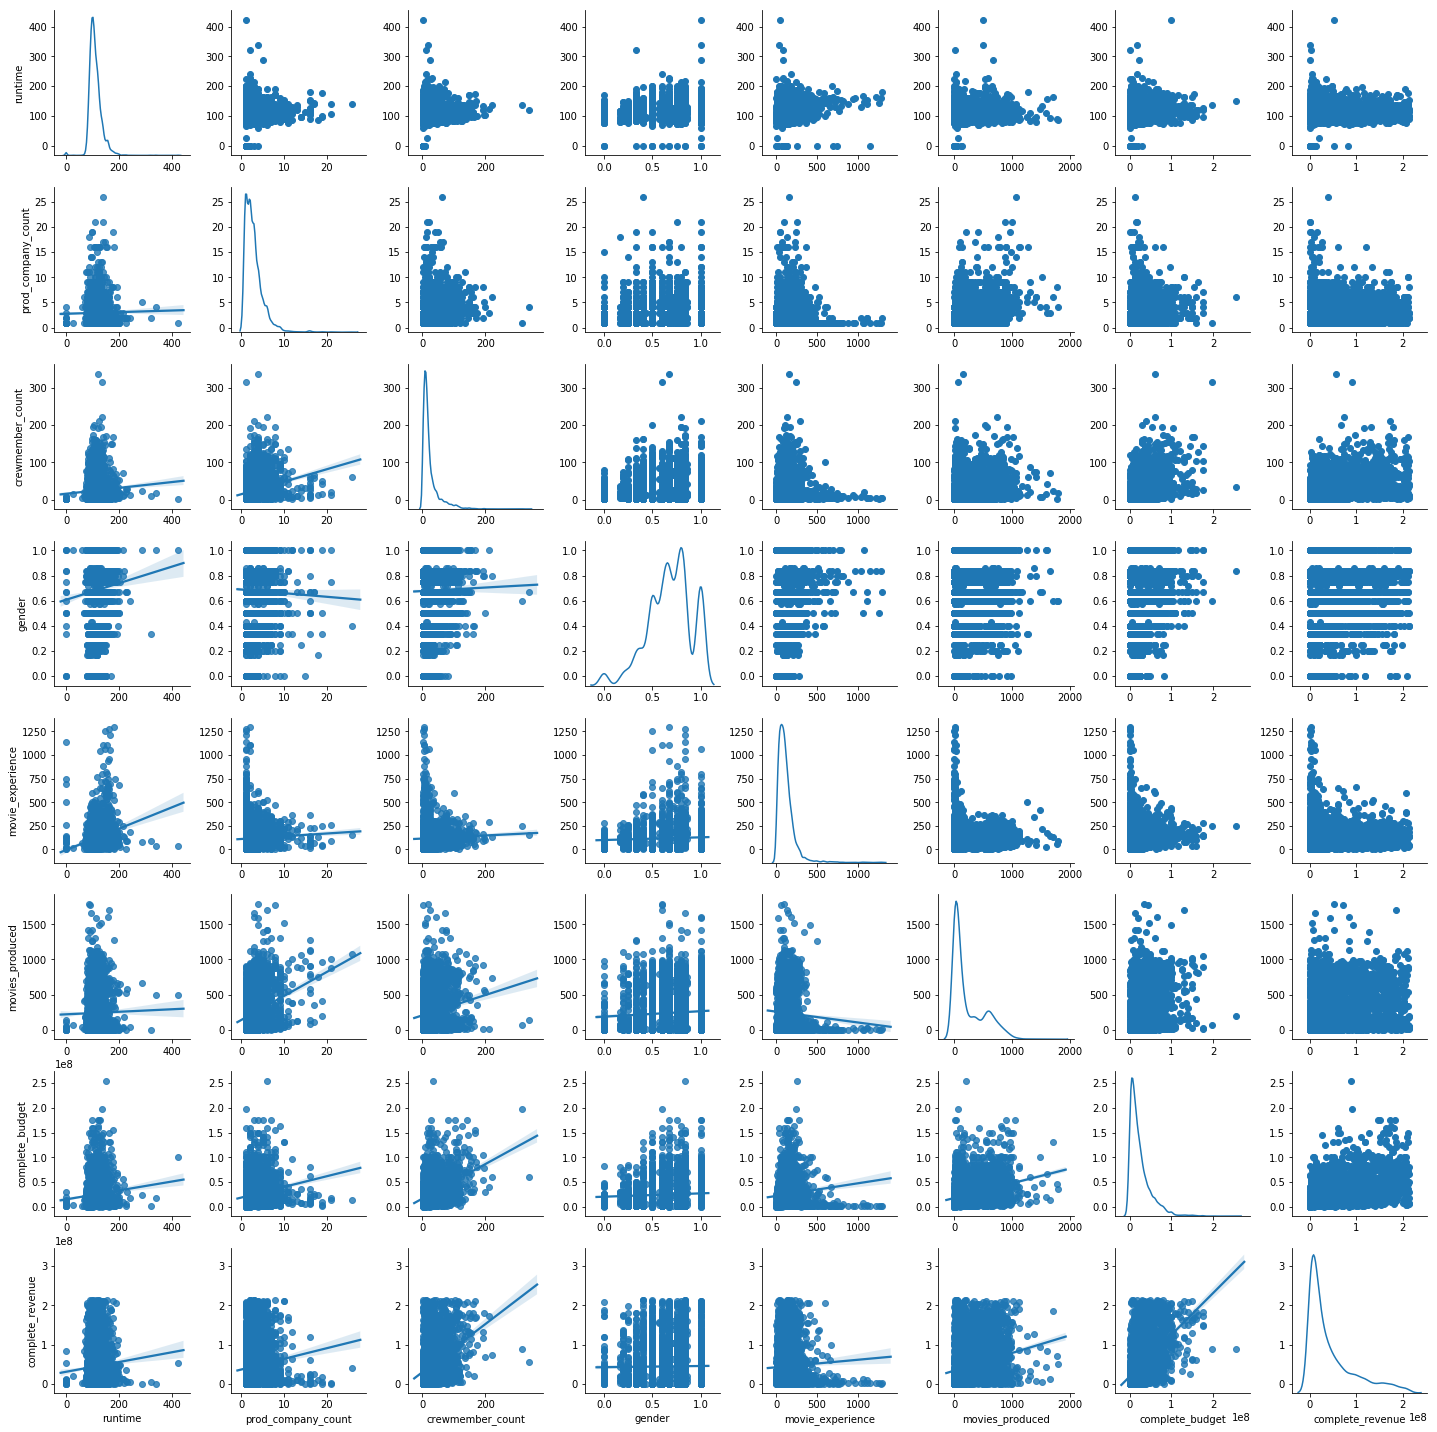

In [193]:
cols = ['runtime','prod_company_count','crewmember_count','gender','movie_experience','movies_produced','complete_budget','complete_revenue']

g = sns.PairGrid(df[cols], diag_sharey=False)
g.map_upper(plt.scatter)
g.map_lower(sns.regplot)
g.map_diag(sns.kdeplot)

plt.show()

In [194]:
df.corr()[['complete_revenue','complete_budget','ROI','gross_margin']]

,complete_revenue,complete_budget,ROI
runtime,0.06,0.08,-0.04
Action,0.08,0.18,-0.01
Adventure,0.12,0.21,-0.02
Animation,0.07,0.11,-0.01
Comedy,0.01,-0.04,-0.02
Crime,-0.00,-0.00,0.00
Documentary,-0.00,-0.05,0.05
Drama,-0.12,-0.11,-0.03
Family,0.10,0.14,-0.03
Fantasy,0.06,0.16,-0.03


In [195]:
drop_genres = set(genres) - set(genre_list)

model_data = df.drop(list(drop_genres),axis=1)
model_data = model_data.drop(['profit','ROI','release_date','title','complete_revenue'],axis=1)
no_budget_model_data = model_data.drop('complete_budget',axis=1)

In [196]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'gross_margin']
y = df_dum['gross_margin']

x_train = x.sample(frac=.8)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'complete_budget', 'is_sequel',
       'is_holiday_False', 'is_holiday_True', 'season_fall', 'season_spring',
       'season_summer', 'season_winter'],
      dtype='object')

In [197]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error


dt = DecisionTreeRegressor(max_depth=10,max_features=None)

dt.fit(x_train,y_train)
y_predict = dt.predict(x_test)
dt.score(x_train,y_train)

0.97045795041797711

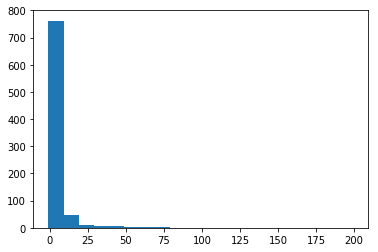

0.072619047619047625

In [198]:
percent_error = (y_predict - y_test) / y_test
plt.hist(percent_error, bins=np.arange(-1,205,10))
plt.show()

np.mean((percent_error < .1) & (percent_error > -.1))

In [199]:
x_test['y_actual'] = y_test
x_test['y_predict'] = y_predict
x_test['y_delta'] = (y_predict - y_test) / y_test
x_test.sort_values('y_delta', ascending=True)

,runtime,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,...,is_sequel,is_holiday_False,is_holiday_True,season_fall,season_spring,season_summer,season_winter,y_actual,y_predict,y_delta
movie_id,,,,,,,,,,,,,,,,,,,,,
9373,98.00,0,0,0,0,0,0,0,1,0,...,False,0,1,1,0,0,0,11.27,0.06,-0.99
151743,105.00,0,0,1,0,0,0,0,0,0,...,False,1,0,0,0,0,1,94.55,2.94,-0.97
83,79.00,0,0,0,0,1,0,0,0,0,...,False,1,0,0,0,1,0,420.52,19.28,-0.95
11951,99.00,1,0,0,0,1,0,0,0,0,...,False,1,0,0,0,0,1,55.59,2.91,-0.95
2108,97.00,0,0,1,0,1,0,0,0,0,...,False,0,1,0,0,0,1,51.53,2.91,-0.94
14373,88.00,1,0,0,1,0,0,0,0,0,...,False,1,0,0,0,0,1,22.50,1.51,-0.93
8193,95.00,0,0,1,0,0,0,0,0,0,...,False,1,0,0,0,1,0,115.30,7.80,-0.93
1781,100.00,0,0,0,0,0,0,0,0,0,...,False,1,0,0,0,0,1,46.24,3.14,-0.93
455,112.00,0,0,1,0,1,0,0,0,0,...,False,1,0,0,1,0,0,21.88,1.76,-0.92


In [200]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'gross_margin']
y = df_dum['gross_margin']

x_train = x.sample(frac=.8)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'complete_budget', 'is_sequel',
       'is_holiday_False', 'is_holiday_True', 'season_fall', 'season_spring',
       'season_summer', 'season_winter'],
      dtype='object')

In [201]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_train,y_train)
y_predict = lr.predict(x_test)

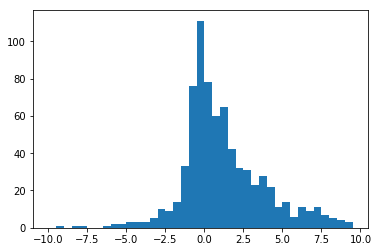

0.050000000000000003

In [202]:
percent_error = (y_predict - y_test) / y_test

plt.hist(percent_error, bins=np.arange(-10,10,.5))
plt.show()
np.mean((percent_error < .1) & (percent_error > -.1))

In [204]:
x_test['y_actual'] = y_test
x_test['y_predict'] = y_predict
x_test['y_delta'] = (y_predict - y_test) / y_test

In [205]:
x_test.sort_values('y_delta', ascending=True)

,runtime,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,...,is_sequel,is_holiday_False,is_holiday_True,season_fall,season_spring,season_summer,season_winter,y_actual,y_predict,y_delta
movie_id,,,,,,,,,,,,,,,,,,,,,
20542,94.00,0,1,1,0,0,1,1,0,0,...,False,1,0,0,0,0,1,0.01,-2.01,-158.44
10077,110.00,1,1,0,0,0,0,0,0,0,...,False,1,0,0,1,0,0,0.07,-2.10,-29.04
64686,119.00,1,1,0,0,1,0,1,0,0,...,False,1,0,0,0,0,1,0.86,-9.47,-11.98
274857,126.00,1,0,0,0,1,0,1,0,0,...,False,1,0,0,1,0,0,0.84,-8.36,-11.01
1911,102.00,1,1,0,0,0,0,1,0,0,...,False,1,0,0,0,1,0,0.39,-3.81,-10.88
291328,127.00,0,0,1,0,1,0,0,0,0,...,False,0,1,1,0,0,0,0.16,-1.45,-10.33
9016,95.00,0,1,0,0,0,1,1,0,0,...,False,0,1,1,0,0,0,0.78,-6.60,-9.44
9447,92.00,0,1,1,0,1,1,1,0,0,...,True,0,1,1,0,0,0,0.77,-5.61,-8.31
1966,175.00,1,1,0,0,1,0,0,0,0,...,False,0,1,1,0,0,0,1.08,-7.42,-7.88


In [206]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'gross_margin']
y = df_dum['gross_margin']

x_train = x.sample(frac=.8)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'complete_budget', 'is_sequel',
       'is_holiday_False', 'is_holiday_True', 'season_fall', 'season_spring',
       'season_summer', 'season_winter'],
      dtype='object')

In [207]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=10,max_features=None)

rf.fit(x_train,y_train)
y_predict = dt.predict(x_test)
rf.score(x_train,y_train)

0.84625536627450804

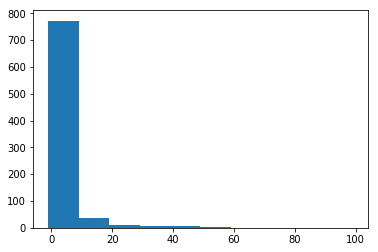

0.09166666666666666

In [208]:
percent_error = (y_predict - y_test) / y_test

plt.hist(percent_error, bins=np.arange(-1,105,10))
plt.show()
np.mean((percent_error < .1) & (percent_error > -.1))

In [209]:
x_test['y_actual'] = y_test
x_test['y_predict'] = y_predict
x_test['y_delta'] = (y_predict - y_test) / y_test
x_test.sort_values('y_delta', ascending=True)

,runtime,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,...,is_sequel,is_holiday_False,is_holiday_True,season_fall,season_spring,season_summer,season_winter,y_actual,y_predict,y_delta
movie_id,,,,,,,,,,,,,,,,,,,,,
9373,98.00,0,0,0,0,0,0,0,1,0,...,False,0,1,1,0,0,0,11.27,0.06,-0.99
8193,95.00,0,0,1,0,0,0,0,0,0,...,False,1,0,0,0,1,0,115.30,7.80,-0.93
37247,106.00,0,0,0,0,1,0,0,0,0,...,False,0,1,0,0,0,1,34.98,2.94,-0.92
146,120.00,1,1,0,0,1,0,0,0,0,...,False,1,0,1,0,0,0,12.56,1.24,-0.90
11298,91.00,0,0,0,0,1,0,0,1,0,...,False,1,0,0,1,0,0,17.99,2.13,-0.88
74534,124.00,0,0,1,0,1,0,0,0,0,...,False,0,1,1,0,0,0,13.68,1.97,-0.86
1777,122.00,0,0,0,0,0,0,0,0,0,...,False,1,0,0,0,1,0,19.85,2.94,-0.85
334543,118.00,0,0,0,0,1,0,0,0,0,...,False,0,1,1,0,0,0,11.61,1.97,-0.83
33,131.00,0,0,0,0,0,0,0,0,0,...,False,1,0,0,0,1,0,11.37,1.97,-0.83


- Try different models
- Play with output variable (log, etc)
- Play with input variables (log of budget)
- Look at feature importance
- Try tpot